# Robust PCA implementation

Saikat Banerjee  
2023-05-16

We implement robust PCA. We use it to decompose the input matrix as the
sum of a low rank matrix and a sparse component.

# About

Our input matrix has missing data. Here, I try to use [Robust PCA by
Candes et. al., 2011](https://doi.org/10.1145/1970392.1970395) to obtain
a low rank matrix $\mathbf{L}$ by stripping out some noise $\mathbf{M}$
and then apply PCA on $\mathbf{L}$ $$
\mathbf{X} = \mathbf{L} + \mathbf{M}
$$

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils

from sklearn.decomposition import PCA

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120, colors = 'kelly')

In [2]:
data_dir = "../data"
beta_df_filename = f"{data_dir}/beta_df.pkl"
prec_df_filename = f"{data_dir}/prec_df.pkl"
beta_df = pd.read_pickle(beta_df_filename)
prec_df = pd.read_pickle(prec_df_filename)

trait_df = pd.read_csv(f"{data_dir}/trait_meta.csv")
phenotype_dict = trait_df.set_index('ID')['Broad'].to_dict()

In [3]:
mean_se = prec_df.apply(lambda x : 1 / np.sqrt(x)).replace([np.inf, -np.inf], np.nan).mean(axis = 0, skipna = True)
mean_se = pd.DataFrame(mean_se).set_axis(["mean_se"], axis = 1)
beta_std = beta_df.std(axis = 0, skipna = True)
beta_std = pd.DataFrame(beta_std).set_axis(["beta_std"], axis = 1)
error_df = pd.concat([mean_se, beta_std], axis = 1)

select_ids = error_df.query("mean_se <= 0.2 and beta_std <= 0.2").index
se_df = prec_df.apply(lambda x : 1 / np.sqrt(x)).replace([np.inf, -np.inf], np.nan)

zscore_df = beta_df / se_df
zscore_df = zscore_df.replace(np.nan, 0)
X = np.array(zscore_df[select_ids]).T
colmeans = np.mean(X, axis = 0, keepdims = True)
Xcent = X - colmeans

labels = [phenotype_dict[x] for x in select_ids]
unique_labels = list(set(labels))

print (f"After filtering, we have {Xcent.shape[0]} samples (phenotypes) and {Xcent.shape[1]} features (variants)")

After filtering, we have 69 samples (phenotypes) and 8403 features (variants)

# Robust PCA

In [4]:
def soft_thresholding(y: np.ndarray, mu: float):
    """
    Soft thresholding operator as explained in Section 6.5.2 of https://web.stanford.edu/~boyd/papers/pdf/prox_algs.pdf
    Solves the following problem:
    argmin_x (1/2)*||x-y||_F^2 + lmb*||x||_1

    Parameters
    ----------
        y : np.ndarray
            Target vector/matrix
        lmb : float
            Penalty parameter
    Returns
    -------
        x : np.ndarray
            argmin solution
    """
    return np.sign(y) * np.clip(np.abs(y) - mu, a_min=0, a_max=None)

def svd_shrinkage(y: np.ndarray, tau: float):
    """
    SVD shrinakge operator as explained in Theorem 2.1 of https://statweb.stanford.edu/~candes/papers/SVT.pdf
    Solves the following problem:
    argmin_x (1/2)*||x-y||_F^2 + tau*||x||_*
    
    Parameters
    ----------
        y : np.ndarray
            Target vector/matrix
        tau : float
            Penalty parameter
    Returns
    -------
        x : np.ndarray
            argmin solution
    
    """
    U, s, Vh = np.linalg.svd(y, full_matrices=False)
    s_t = soft_thresholding(s, tau)
    return U.dot(np.diag(s_t)).dot(Vh)

class RobustPCA:
    """
    Solves robust PCA using Inexact ALM as explained in Algorithm 5 of https://arxiv.org/pdf/1009.5055.pdf
    Parameters
    ----------
        lmb: 
            penalty on sparse errors
        mu_0: 
            initial lagrangian penalty
        rho: 
            learning rate
        tau:
            mu update criterion parameter
        max_iter:
            max number of iterations for the algorithm to run
        tol_rel:
            relative tolerance
        
    """
    def __init__(self, lmb: float, mu_0: float=1e-5, rho: float=2, tau: float=10, 
                 max_iter: int=10, tol_rel: float=1e-3):
        assert mu_0 > 0
        assert lmb > 0
        assert rho > 1
        assert tau > 1
        assert max_iter > 0
        assert tol_rel > 0
        self.mu_0_ = mu_0
        self.lmb_ = lmb
        self.rho_ = rho
        self.tau_ = tau
        self.max_iter_ = max_iter
        self.tol_rel_ = tol_rel
        
    def fit(self, X: np.ndarray):
        """
        Fits robust PCA to X and returns the low-rank and sparse components
        Parameters
        ----------
            X:
                Original data matrix

        Returns
        -------
            L:
                Low rank component of X
            S:
                Sparse error component of X
        """
        assert X.ndim == 2
        mu = self.mu_0_
        Y = X / self._J(X, mu)
        S = np.zeros_like(X)
        S_last = np.empty_like(S)
        for k in range(self.max_iter_):
            # Solve argmin_L ||X - (L + S) + Y/mu||_F^2 + (lmb/mu)*||L||_*
            L = svd_shrinkage(X - S + Y/mu, 1/mu)
            
            # Solve argmin_S ||X - (L + S) + Y/mu||_F^2 + (lmb/mu)*||S||_1
            S_last = S.copy()
            S = soft_thresholding(X - L + Y/mu, self.lmb_/mu)
            
            # Update dual variables Y <- Y + mu * (X - S - L)
            Y += mu*(X - S - L)
            r, h = self._get_residuals(X, S, L, S_last, mu)
            
            # Check stopping cirteria
            tol_r, tol_h = self._update_tols(X, L, S, Y)
            if r < tol_r and h < tol_h:
                break
                
            # Update mu
            mu = self._update_mu(mu, r, h)
            
        return L, S
            
    def _J(self, X: np.ndarray, lmb: float):
        """
        The function J() required for initialization of dual variables as advised in Section 3.1 of 
        https://people.eecs.berkeley.edu/~yima/matrix-rank/Files/rpca_algorithms.pdf            
        """
        return max(np.linalg.norm(X), np.max(np.abs(X))/lmb)
    
    @staticmethod
    def _get_residuals(X: np.ndarray, S: np.ndarray, L: np.ndarray, S_last: np.ndarray, mu: float):
        primal_residual = np.linalg.norm(X - S - L, ord="fro")
        dual_residual = mu * np.linalg.norm(S - S_last, ord="fro")
        return primal_residual, dual_residual
    
    def _update_mu(self, mu: float, r: float, h: float):
        if r > self.tau_ * h:
            return mu * self.rho_
        elif h > self.tau_ * r:
            return mu / self.rho_
        else:
            return mu
        
    def _update_tols(self, X, S, L, Y):
        tol_primal = self.tol_rel_ * max(np.linalg.norm(X), np.linalg.norm(S), np.linalg.norm(L))
        tol_dual = self.tol_rel_ * np.linalg.norm(Y)
        return tol_primal, tol_dual

In [5]:
rpca = RobustPCA(lmb=0.0085, max_iter=1000)
L, M = rpca.fit(Xcent)

In [6]:
U, S, Vt = np.linalg.svd(Xcent, full_matrices=False)
pca_proj = U @ np.diag(S)

In [7]:
Lcent = L - np.mean(L, axis = 0, keepdims = True)
Mcent = M - np.mean(M, axis = 0, keepdims = True)

In [8]:
U_rpca, S_rpca, Vt_rpca = np.linalg.svd(Lcent, full_matrices = False)
rpca_proj = U_rpca @ np.diag(S_rpca)

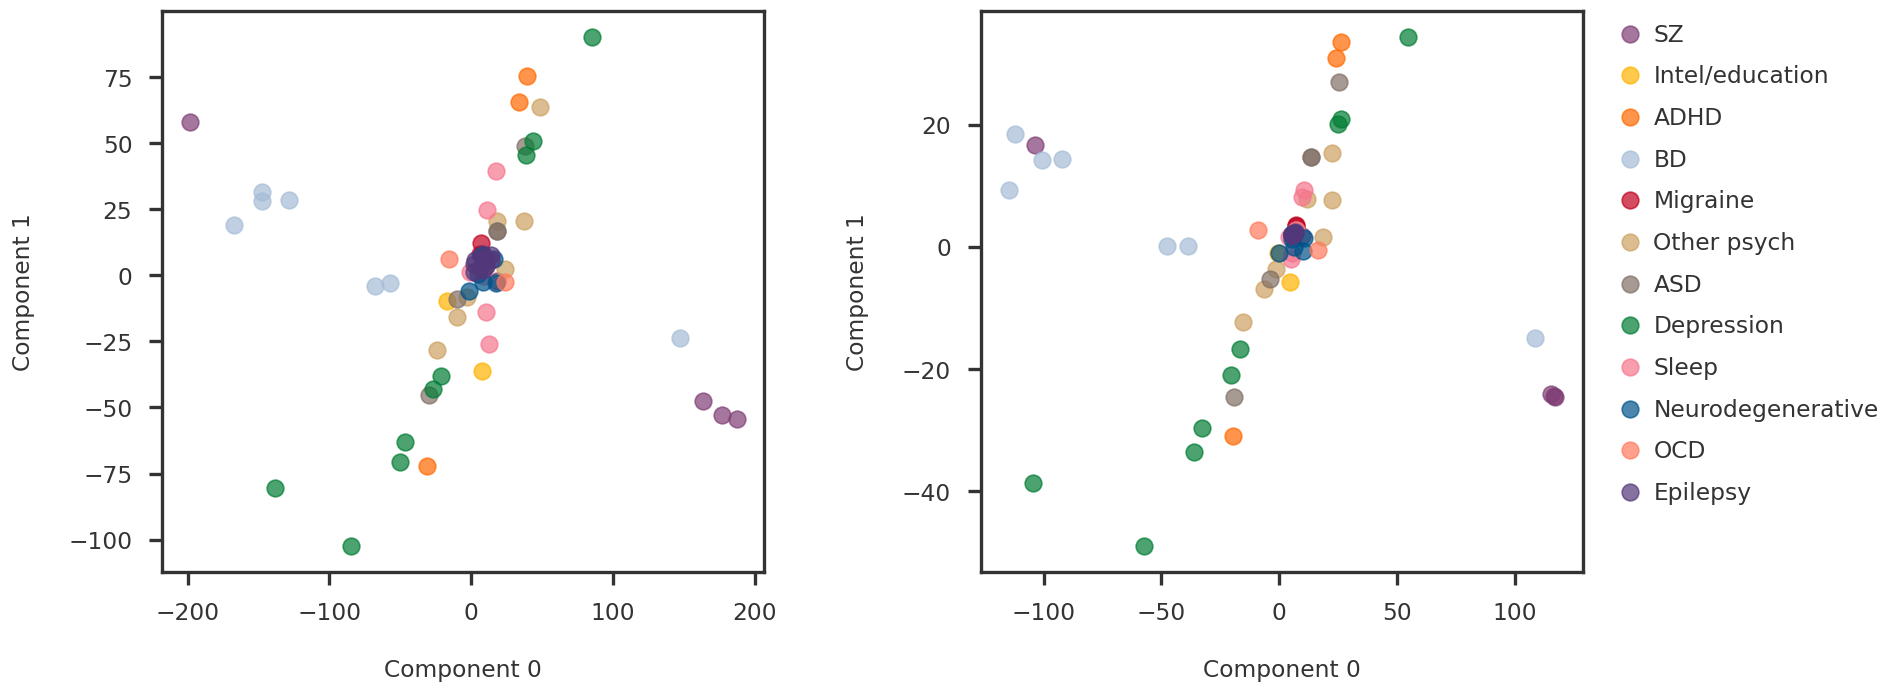

In [9]:
idx1 = 0
idx2 = 1

svd_pc1 = pca_proj[:, idx1]
svd_pc2 = pca_proj[:, idx2]
rpca_pc1 = rpca_proj[:, idx1]
rpca_pc2 = rpca_proj[:, idx2]

fig = plt.figure(figsize = (16, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for label in unique_labels:
    idx = np.array([i for i, x in enumerate(labels) if x == label])
    ax1.scatter(svd_pc1[idx], svd_pc2[idx], s = 100, alpha = 0.7, label = label)
    ax2.scatter(rpca_pc1[idx], rpca_pc2[idx], s = 100, alpha = 0.7, label = label)
    
ax2.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
ax1.set_xlabel(f"Component {idx1}")
ax1.set_ylabel(f"Component {idx2}")
ax2.set_xlabel(f"Component {idx1}")
ax2.set_ylabel(f"Component {idx2}")

plt.tight_layout(w_pad = 3)
plt.show()

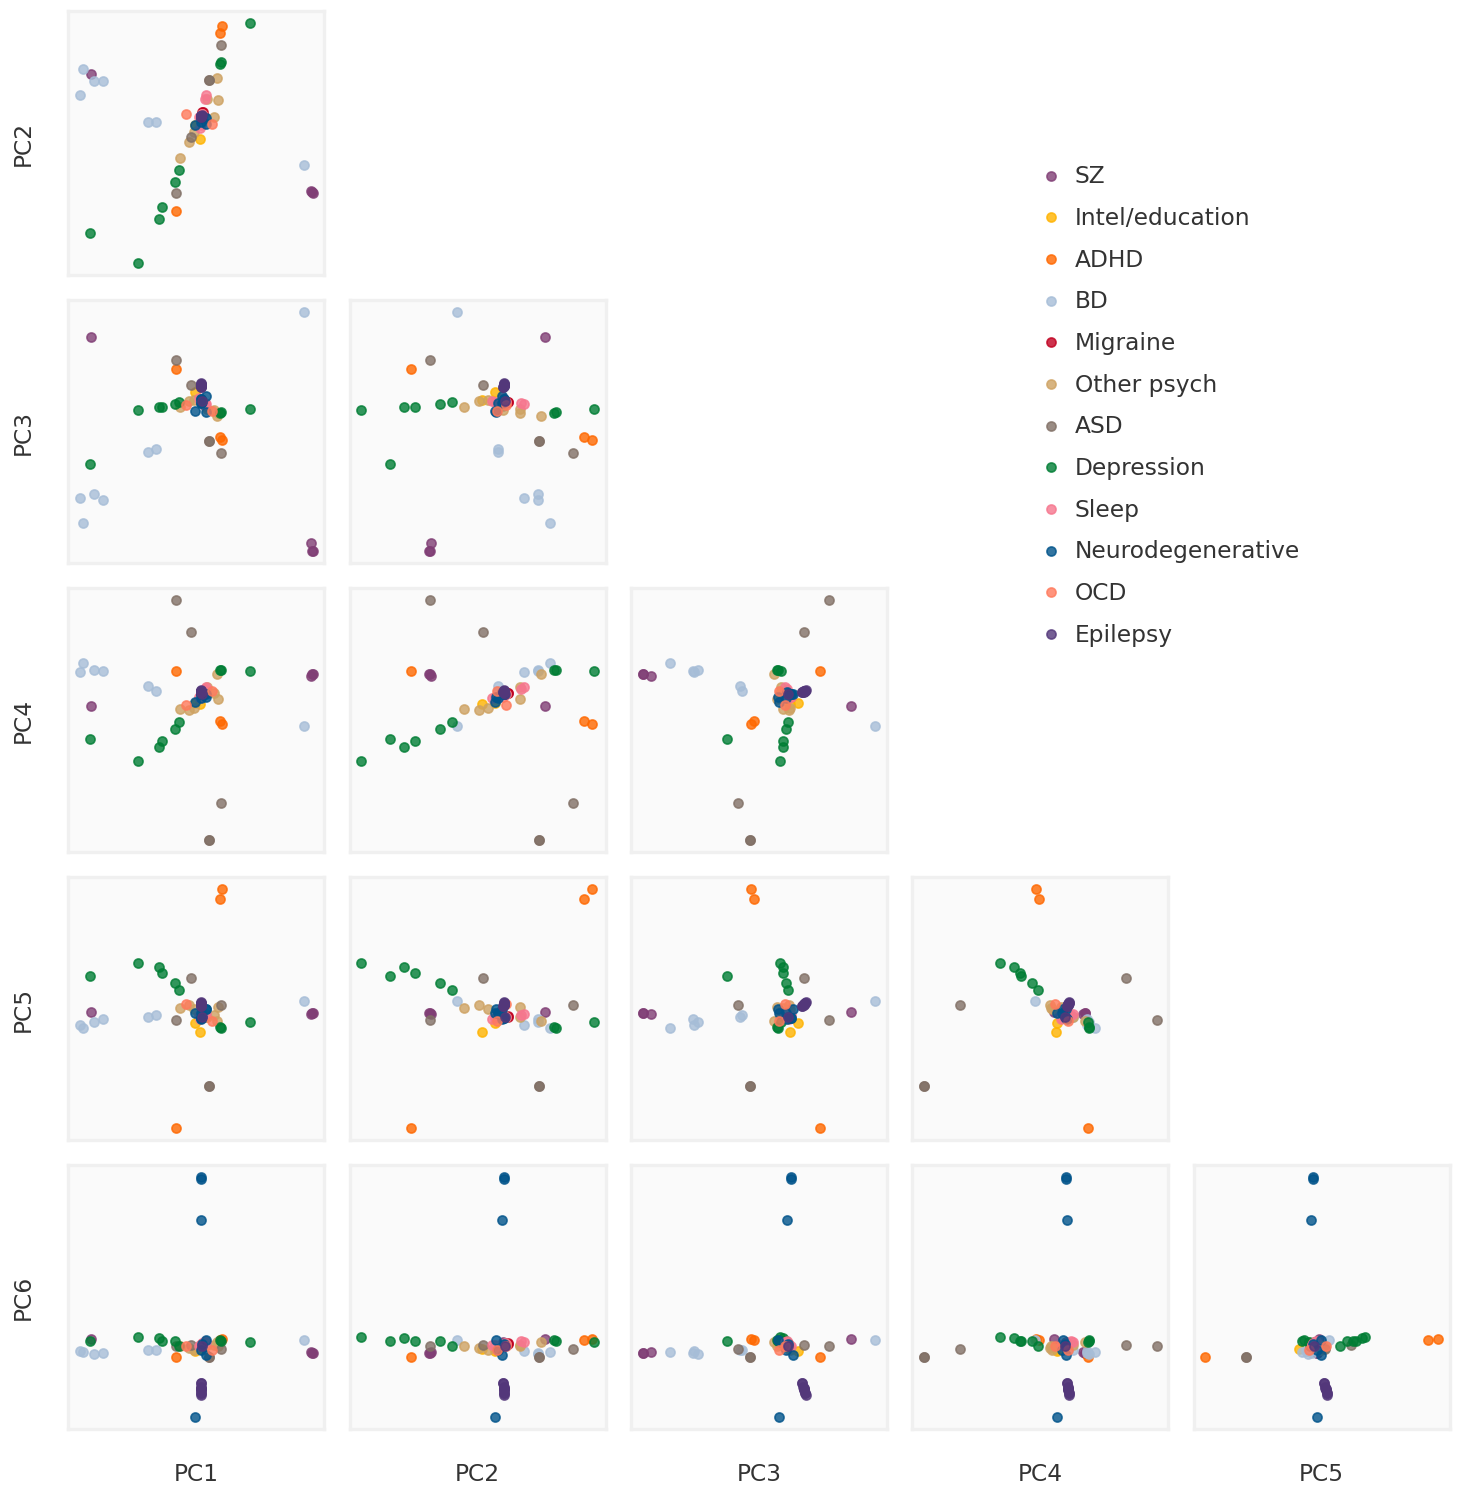

In [10]:
plot_ncomp = 6
subplot_h = 2.0

nrow = plot_ncomp - 1
ncol = plot_ncomp - 1
figw = ncol * subplot_h + (ncol - 1) * 0.3 + 1.2
figh = nrow * subplot_h + (nrow - 1) * 0.3 + 1.5
bgcolor = '#F0F0F0'


def make_plot_principal_components(ax, i, j, comp):
    pc1 = comp[:, j]
    pc2 = comp[:, i]
    for label in unique_labels:
        idx = np.array([k for k, x in enumerate(labels) if x == label])
        ax.scatter(pc1[idx], pc2[idx], s = 30, alpha = 0.8, label = label)
    return

fig = plt.figure(figsize = (figw, figh))
axmain = fig.add_subplot(111)

for i in range(1, nrow + 1):
    for j in range(ncol):
        ax = fig.add_subplot(nrow, ncol, ((i - 1) * ncol) + j + 1)
        
        ax.tick_params(bottom = False, top = False, left = False, right = False,
                       labelbottom = False, labeltop = False, labelleft = False, labelright = False)
        if j == 0: ax.set_ylabel(f"PC{i + 1}")
        if i == nrow: ax.set_xlabel(f"PC{j + 1}")
        if i > j:
            ax.patch.set_facecolor(bgcolor)
            ax.patch.set_alpha(0.3)
            make_plot_principal_components(ax, i, j, rpca_proj)
            for side, border in ax.spines.items():
                border.set_color(bgcolor)
        else:
            ax.patch.set_alpha(0.)
            for side, border in ax.spines.items():
                border.set_visible(False)
                
        if i == 1 and j == 0:
            mhandles, mlabels = ax.get_legend_handles_labels()

axmain.tick_params(bottom = False, top = False, left = False, right = False,
                   labelbottom = False, labeltop = False, labelleft = False, labelright = False)
for side, border in axmain.spines.items():
    border.set_visible(False)
axmain.legend(handles = mhandles, labels = mlabels, loc = 'upper right', bbox_to_anchor = (0.9, 0.9))
          
        
plt.tight_layout()
plt.show()

In [11]:
np.linalg.matrix_rank(L)

14

In [12]:
np.linalg.matrix_rank(M)

68